# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

***Описание проекта***

Заказчик этого исследования — сеть отелей «Как в гостях».
Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.
Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера. Деньги будут списаны со счёта клиента, если он всё же отменит бронь

***Бизнес-модель и другие данные***

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на разовое обслуживание: как при подготовке номера, так и при проживании постояльца.
В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.
Стоимость номеров отеля:
* категория A: за ночь — 1 000, разовое обслуживание — 400;
* категория B: за ночь — 800, разовое обслуживание — 250;
* категория C: за ночь — 600, разовое обслуживание — 250;
* категория D: за ночь — 550, разовое обслуживание — 150;
* категория E: за ночь — 500, разовое обслуживание — 150;
* категория F: за ночь — 400, разовое обслуживание — 150;
* категория G: за ночь — 350, разовое обслуживание — 150;
* категория H: за ночь — 300, разовое обслуживание — 100.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.


***Расшифровка столбцов***

* ADR — средняя дневная загрузка;
* Adults — количество взрослых постояльцев;
* Agent — агент, через которого сделан заказ;
* AssignedRoomType — тип номера;
* Babies — количество младенцев;
* BookingChanges — количество изменений параметров заказа;
* Children — количество детей от 3 до 14 лет;
* CompanyID — ID компании или юридического лица, ответственных за бронирование.
* Country — гражданство постояльца;
* CustomerType — тип заказчика:
    * Contract — договор с юридическим лицом;
    * Group — групповой заезд;
    * Transient — не связано с договором или групповым заездом;
    * Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
* DaysInWaitingList — сколько дней заказ ожидал подтверждения;
* DistributionChannel — канал дистрибуции заказа;
* IsCanceled — отмена заказа;
* IsRepeatedGuest — признак того, что гость бронирует номер второй раз;
* LeadTime — количество дней между датой бронирования и датой прибытия;
* Meal — опции заказа:
    * SC — нет дополнительных опций;
    * BB — включён завтрак;
    * HB — включён завтрак и обед;
    * FB — включён завтрак, обед и ужин.
* PreviousBookingsNotCanceled — количество подтверждённых заказов у клиента;
* PreviousCancellations — количество отменённых заказов у клиента;
* RequiredCardParkingSpaces — необходимость места для автомобиля;
* ReservedRoomType — тип забронированной комнаты;
* StaysInWeekendNights — количество ночей в выходные дни;
* StaysInWeekNights — количество ночей в будние дни;
* TotalOfSpecialRequests — количество специальных отметок.

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from hyperopt.pyll.base import scope
from functools import partial
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from hyperopt.early_stop import no_progress_loss
from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 40)
sns.set(style="darkgrid")

## Шаг 1. Откройте файлы с данными

In [4]:
train = pd.read_csv('https://code.s3.yandex.net/datasets/hotel_train.csv')
test = pd.read_csv('https://code.s3.yandex.net/datasets/hotel_test.csv')

***По условиям задачи данные в признаках adr и price не учитываются. Такие столбцы удалим.***

In [5]:
lst_of_frame_names = ('train_data', 'test_data')

## Шаг 2. Предобработка и исследовательский анализ данных

### Рассмотрим данные

In [6]:
for frame, frame_name in zip((train, test), lst_of_frame_names):
    name_string = '| ' + frame_name + ' |'
    label_string = '-' * len(name_string)
    print(label_string)
    print(name_string)
    print(label_string)
    display(frame.head())
    print()

--------------
| train_data |
--------------


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.000,2015,July,27,1,0,1,1.000,0.000,0.000,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.000,2015,July,27,1,0,2,2.000,0.000,0.000,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.000,2015,July,27,1,0,2,2.000,0.000,0.000,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.000,2015,July,27,1,0,2,2.000,0.000,0.000,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.000,2015,July,27,1,0,3,2.000,0.000,0.000,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3



-------------
| test_data |
-------------


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.000,2017,January,1,1,1,0,2.000,0.000,0.000,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.000,2017,January,1,1,2,2,2.000,0.000,0.000,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.000,2017,January,1,1,2,2,2.000,0.000,0.000,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.000,2017,January,1,1,2,2,1.000,0.000,0.000,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.000,2017,January,1,1,2,5,2.000,0.000,0.000,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


In [7]:
for frame, frame_name in zip((train, test), lst_of_frame_names):
    name_string = '| ' + frame_name + ' |'
    label_string = '-' * len(name_string)
    print(label_string)
    print(name_string)
    print(label_string)
    display(frame.info())

--------------
| train_data |
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  

None

-------------
| test_data |
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  flo

None

***Просмотрим значения в переменных***

In [8]:
train.nunique().sort_values()

is_canceled                           2
arrival_date_year                     2
is_repeated_guest                     2
required_car_parking_spaces           4
customer_type                         4
children                              4
distribution_channel                  4
meal                                  5
stays_in_weekend_nights               5
adults                                5
babies                                5
total_of_special_requests             6
reserved_room_type                    7
stays_in_week_nights                  7
total_nights                         10
arrival_date_month                   12
previous_cancellations               15
booking_changes                      16
arrival_date_day_of_month            31
arrival_date_week_number             53
previous_bookings_not_canceled       58
days_in_waiting_list                 97
country                             155
lead_time                           369
id                                65229


Нас интересуют больше категориальные переменные

In [9]:
cat_features = train.select_dtypes(include=['object']).columns
print(cat_features)

Index(['arrival_date_month', 'meal', 'country', 'distribution_channel',
       'reserved_room_type', 'customer_type'],
      dtype='object')


### Удаление лишних пробелов в значениях признаков.

Возможные проблемы с категориальными переменными:
* В значениях присуствуют лишние пробелы;
* В значениях используется в перемешку строчные/заглавные буквы.

In [10]:
for col in cat_features:
    name_string = '| ' + col + ' |'
    label_string = '-' * len(col)
    print(label_string)
    print(name_string)
    print(label_string)
    display(sorted(train[train[col].notna()][col].unique()))

------------------
| arrival_date_month |
------------------


['April',
 'August',
 'December',
 'February',
 'January',
 'July',
 'June',
 'March',
 'May',
 'November',
 'October',
 'September']

----
| meal |
----


['BB       ', 'FB       ', 'HB       ', 'SC', 'SC       ']

-------
| country |
-------


['ABW',
 'AGO',
 'ALB',
 'AND',
 'ARE',
 'ARG',
 'ARM',
 'ATA',
 'AUS',
 'AUT',
 'AZE',
 'BDI',
 'BEL',
 'BEN',
 'BFA',
 'BGD',
 'BGR',
 'BHR',
 'BIH',
 'BLR',
 'BOL',
 'BRA',
 'BRB',
 'BWA',
 'CHE',
 'CHL',
 'CHN',
 'CIV',
 'CMR',
 'CN',
 'COL',
 'CPV',
 'CRI',
 'CUB',
 'CYM',
 'CYP',
 'CZE',
 'DEU',
 'DMA',
 'DNK',
 'DOM',
 'DZA',
 'ECU',
 'EGY',
 'ESP',
 'EST',
 'ETH',
 'FIN',
 'FRA',
 'GAB',
 'GBR',
 'GEO',
 'GGY',
 'GIB',
 'GLP',
 'GNB',
 'GRC',
 'GUY',
 'HKG',
 'HND',
 'HRV',
 'HUN',
 'IDN',
 'IMN',
 'IND',
 'IRL',
 'IRN',
 'IRQ',
 'ISL',
 'ISR',
 'ITA',
 'JAM',
 'JEY',
 'JOR',
 'JPN',
 'KAZ',
 'KEN',
 'KHM',
 'KNA',
 'KOR',
 'KWT',
 'LBN',
 'LBY',
 'LCA',
 'LIE',
 'LKA',
 'LTU',
 'LUX',
 'LVA',
 'MAC',
 'MAR',
 'MCO',
 'MDV',
 'MEX',
 'MKD',
 'MLI',
 'MLT',
 'MMR',
 'MNE',
 'MOZ',
 'MUS',
 'MWI',
 'MYS',
 'NAM',
 'NGA',
 'NIC',
 'NLD',
 'NOR',
 'NZL',
 'OMN',
 'PAK',
 'PAN',
 'PER',
 'PHL',
 'PLW',
 'POL',
 'PRI',
 'PRT',
 'PRY',
 'PYF',
 'QAT',
 'ROU',
 'RUS',
 'RWA',
 'SAU',
 

--------------------
| distribution_channel |
--------------------


['Corporate', 'Direct', 'GDS', 'TA/TO']

------------------
| reserved_room_type |
------------------


['A               ',
 'B               ',
 'C               ',
 'D               ',
 'E               ',
 'F               ',
 'G               ']

-------------
| customer_type |
-------------


['Contract', 'Group', 'Transient', 'Transient-Party']

In [11]:
columns_with_extra_spaces = ['meal', 'reserved_room_type']
print(f'Столбцы, где есть лишние пробелы в значениях: {columns_with_extra_spaces}')

Столбцы, где есть лишние пробелы в значениях: ['meal', 'reserved_room_type']


Напишем функцию, которая будет перезаписывать значения с лишними пробелами в датафрейме. Такая функция на вход будет принимать датафрейм и список со столбцами.

In [12]:
def del_extra_spaces_in_columns(data, columns):
    for col in columns:
        data.loc[data[col].notna(), col] = data.loc[data[col].notna(), col].str.strip().copy()

In [13]:
del_extra_spaces_in_columns(train, columns_with_extra_spaces)
del_extra_spaces_in_columns(test, columns_with_extra_spaces)

In [14]:
#Проверка
for col in columns_with_extra_spaces:
    name_string = '| ' + col + ' |'
    label_string = '-' * len(col)
    print(label_string)
    print(name_string)
    print(label_string)
    display(sorted(train[train[col].notna()][col].unique()))

----
| meal |
----


['BB', 'FB', 'HB', 'SC']

------------------
| reserved_room_type |
------------------


['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [15]:
for col in columns_with_extra_spaces:
    name_string = '| ' + col + ' |'
    label_string = '-' * len(col)
    print(label_string)
    print(name_string)
    print(label_string)
    display(sorted(test[test[col].notna()][col].unique()))

----
| meal |
----


['BB', 'FB', 'HB', 'SC']

------------------
| reserved_room_type |
------------------


['A', 'B', 'C', 'D', 'E', 'F', 'G']

### Обработка пропусков

In [16]:
temp = train.isna().mean().sort_values(ascending=False).to_frame(name='ratio_nan')
display(temp.head(7))
columns_with_nan = temp[temp['ratio_nan'] != 0].index.values
print()
print(f'Столбцы, где есть пропуски: Пропуски отсутствуют')

,ratio_nan
id,0.000
country,0.000
total_of_special_requests,0.000
required_car_parking_spaces,0.000
customer_type,0.000
days_in_waiting_list,0.000
booking_changes,0.000



Столбцы, где есть пропуски: Пропуски отсутствуют


In [19]:
test.isna().sum().sum()

0

### Изменение типов данных

Теперь можем переопределить типы данных, где были пропущены значения

In [20]:
temp_types = train.dtypes.to_frame(name='type')
temp_types = temp_types.join(train.nunique().to_frame(name='nunique'))
temp_types = temp_types[temp_types['type'] == 'float64'].sort_values(by='nunique')
display(temp_types)

,type,nunique
children,float64,4
adults,float64,5
babies,float64,5
lead_time,float64,369


In [21]:
train[temp_types.index.values] = train[temp_types.index.values].astype('int')
test[temp_types.index.values] = test[temp_types.index.values].astype('int')

In [22]:
train.dtypes.to_frame().query('index in @temp_types.index.values')

,0
lead_time,int64
adults,int64
children,int64
babies,int64


### Распределение данных. Мультиколлинеарность признаков

Просмотрим численные значения с помощью метода *describe*

In [23]:
train.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000
mean,43544.069,0.369,96.338,2015.719,31.340,15.848,0.825,2.225,1.837,0.075,0.007,0.027,0.129,0.108,0.194,3.334,0.057,0.513,3.050
std,25614.859,0.482,96.128,0.449,13.464,8.748,0.853,1.355,0.480,0.334,0.099,0.163,0.965,1.327,0.594,18.240,0.232,0.753,1.738
min,0.000,0.000,0.000,2015.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
25%,19108.000,0.000,17.000,2015.000,21.000,8.000,0.000,1.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000
50%,40554.000,0.000,64.000,2016.000,34.000,16.000,1.000,2.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000
75%,67414.000,1.000,151.000,2016.000,42.000,23.000,2.000,3.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,4.000
max,84121.000,1.000,374.000,2016.000,53.000,31.000,4.000,6.000,4.000,3.000,10.000,1.000,26.000,58.000,17.000,259.000,3.000,5.000,10.000


In [24]:
sorted(train.columns)

['adults',
 'arrival_date_day_of_month',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_year',
 'babies',
 'booking_changes',
 'children',
 'country',
 'customer_type',
 'days_in_waiting_list',
 'distribution_channel',
 'id',
 'is_canceled',
 'is_repeated_guest',
 'lead_time',
 'meal',
 'previous_bookings_not_canceled',
 'previous_cancellations',
 'required_car_parking_spaces',
 'reserved_room_type',
 'stays_in_week_nights',
 'stays_in_weekend_nights',
 'total_nights',
 'total_of_special_requests']

О! Есть посетители с 10 детьми. Посмотрим вообще распределение в *babies*

In [25]:
train['babies'].value_counts()

0     64777
1       447
2         3
10        1
9         1
Name: babies, dtype: int64

Строчек, где 9 или 10 детей всего 2. Можно их удалить

In [26]:
len(train)

65229

In [27]:
train = train[train['babies'] < 9]

In [28]:
len(train)

65227

Также стоит посмотреть previous_cancellations и previous_bookings_not_canceled

In [29]:
train['previous_cancellations'].value_counts()

0     59589
1      5367
2        54
3        51
11       35
24       28
25       19
26       18
19       17
5        13
13       12
14       11
6         7
4         5
21        1
Name: previous_cancellations, dtype: int64

In [30]:
train['previous_bookings_not_canceled'].value_counts().sort_index()

0     63684
1       645
2       252
3       136
4       114
5        89
6        56
7        34
8        25
9        23
10       21
11       16
12       14
13        9
14        8
15        7
16        6
17        5
18        5
19        5
20        5
21        8
22        7
23        2
24        3
25       10
26        1
27        3
28        2
29        2
30        1
31        1
32        1
33        1
34        1
35        1
36        1
37        1
38        1
39        1
40        1
41        1
42        1
43        1
44        2
45        1
47        1
48        2
49        1
50        1
51        1
52        1
53        1
54        1
55        1
56        1
57        1
58        1
Name: previous_bookings_not_canceled, dtype: int64

Значения больше 12 редки, тоже дропнем такие строки

In [31]:
len(train)

65227

In [32]:
train = train[train['previous_bookings_not_canceled'] < 12]

In [33]:
len(train)

65095

In [34]:
65227 - 65095 

132

Следующий столбец booking_changes

In [35]:
train['booking_changes'].value_counts()

0     56094
1      6591
2      1749
3       409
4       149
5        42
6        19
7        18
8         7
9         5
13        4
10        2
14        2
15        2
16        1
17        1
Name: booking_changes, dtype: int64

Дропнем все, что больше 8

In [36]:
train = train[train['booking_changes'] < 9]

И еще days_in_waiting_list

In [37]:
train['days_in_waiting_list'].value_counts().sort_index()

0      61862
1          3
2          2
3         59
4         20
5          2
6         11
8          4
9         13
10        27
11         4
12         2
13         1
14         1
15        52
17        43
19        30
20        25
21        35
22        52
24        19
25        18
27        23
28        45
30         1
31       118
32        18
33         4
34        20
35        95
38        72
39       185
40        28
41        63
42        30
43        16
44       137
45        65
46        87
47        17
48        51
49        15
50        75
53         5
55        10
56        42
57        24
58       164
59         8
60        34
61        15
62        60
63        80
65        27
68        41
69        89
70        18
71         7
72         1
74         1
75        36
76         1
77        63
79        20
80        23
81         1
85        15
87        80
89         1
91        50
93        38
96        46
98        55
99        16
101       60
107        3
108       20

(0.0, 50.0)

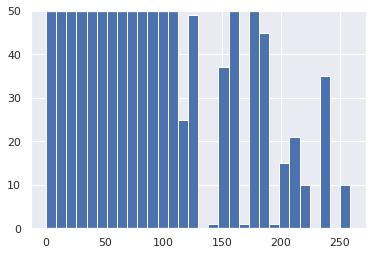

In [38]:
train['days_in_waiting_list'].hist(bins=30)
plt.ylim(0, 50)

Этот столбец не будем обрабатывать

В глаза бросаются следующие столбцы, где возможно есть выбросные значения: *lead_time*, *previous_cancellations*, *previous_bookings_not_canceled*, *booking_changes*, *days_in_waiting_list*. Построим гистограммы для этих признаков.

In [39]:
columns_to_research = [
    ['lead_time',
    'previous_cancellations'],
    ['previous_bookings_not_canceled',
    'booking_changes'],
    ['days_in_waiting_list',
    'required_car_parking_spaces']
]

In [40]:
def draw_hist(frame, columns_to_plot_hist, bins=50):
    
    fig, axs = plt.subplots(ncols=len(columns_to_plot_hist[0]),
                            nrows=len(columns_to_plot_hist),
                            figsize = (20,15))
    
    for j in range(len(columns_to_plot_hist)):
        for i in range(len(columns_to_plot_hist[j])):
            sns.histplot(data=frame,
                         x=columns_to_plot_hist[j][i],
                         hue='is_canceled',
                         bins=bins, ax=axs[j, i])

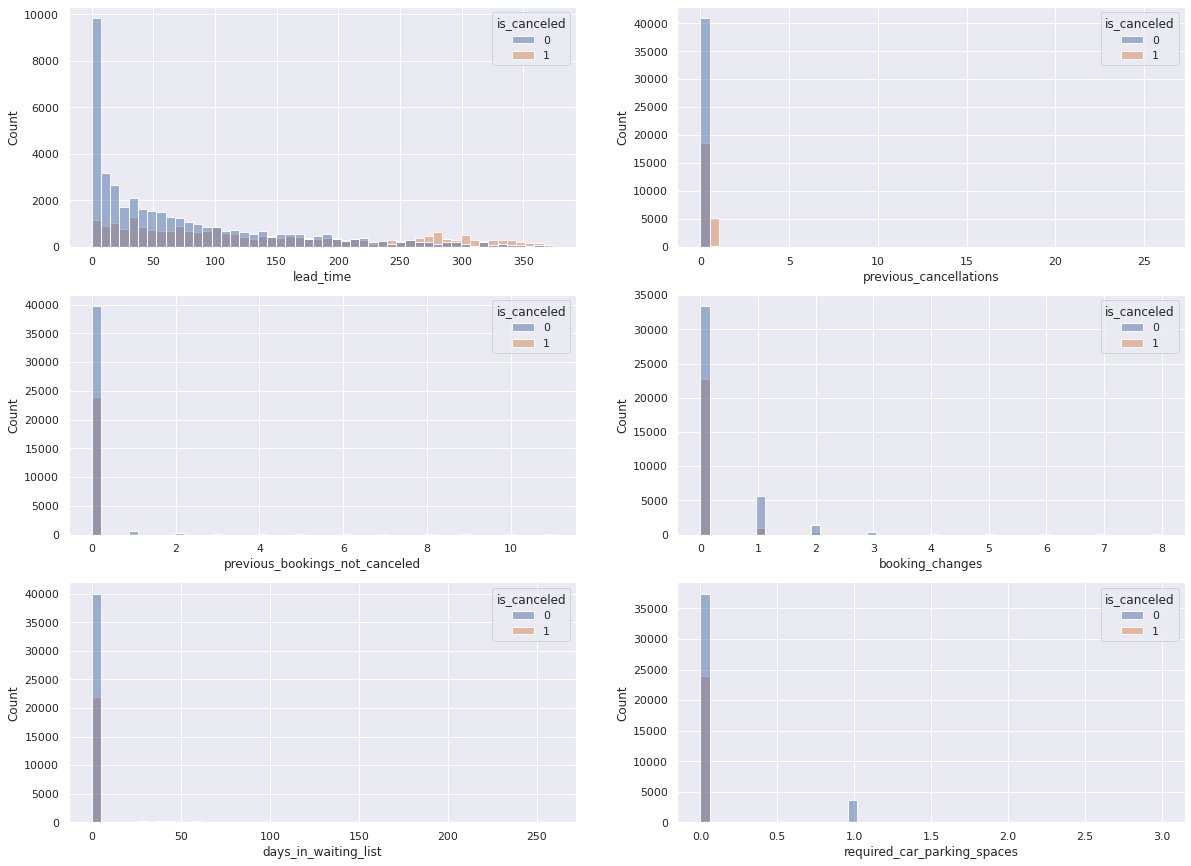

In [41]:
draw_hist(train, columns_to_research)

Графическое отображение гистограмм сверху. В данных все равно есть выбросы, если модель будет плохо обучаться, то удалим больше выбросных значений.

In [42]:
temp_types = train.dtypes.to_frame(name='type')
temp_types = temp_types.join(train.nunique().to_frame(name='nunique'))

In [43]:
temp_types[
            (temp_types['type'] != 'object')
            & (temp_types['nunique'] > 2)
          ].sort_values('nunique')

,type,nunique
babies,int64,3
children,int64,4
required_car_parking_spaces,int64,4
stays_in_weekend_nights,int64,5
adults,int64,5
total_of_special_requests,int64,6
stays_in_week_nights,int64,7
booking_changes,int64,9
total_nights,int64,10
previous_bookings_not_canceled,int64,12


In [44]:
num_features = [
    'babies',
    'required_car_parking_spaces',
    'adults',
    'children',
    'stays_in_weekend_nights',
    'total_of_special_requests',
    'stays_in_week_nights',
    'total_nights',
    'previous_cancellations',
    'booking_changes',
    'previous_bookings_not_canceled',
    'days_in_waiting_list',
    'lead_time'
]

Определим также сразу категориальные признаки

Добавим категориальные признаки по типу object в переменную cat_features

In [45]:
cat_features = temp_types[temp_types['type'] == 'object'].index.values.tolist()
print(cat_features)

['arrival_date_month', 'meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type']


Также добавим категориальные признаки с типом int

In [46]:
temp_types[(temp_types['type'] == 'int64')
          & (temp_types['nunique'] == 2)
          ]

,type,nunique
is_canceled,int64,2
arrival_date_year,int64,2
is_repeated_guest,int64,2


In [47]:
cat_features.append('is_repeated_guest')

print(cat_features)

['arrival_date_month', 'meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type', 'is_repeated_guest']


In [48]:
train['arrival_date_year'].value_counts()

2016    46754
2015    18324
Name: arrival_date_year, dtype: int64

In [49]:
test['arrival_date_year'].value_counts()

2017    32412
Name: arrival_date_year, dtype: int64

Посмотрим также процент клиентов, которые отменили бронирование по годам

In [55]:
train.groupby(['arrival_date_year'])['is_canceled'].value_counts(normalize=True)

arrival_date_year  is_canceled
2015               0             0.608
                   1             0.392
2016               0             0.640
                   1             0.360
Name: is_canceled, dtype: float64

In [56]:
test['is_canceled'].mean()

0.3884672343576453

Соотношение примерно равное. Здесь может быть зависимость скорее сезонная (по месяцам). Ниже сделаем график

In [100]:
q_temp = \
train.groupby(
    'arrival_date_month'
)['is_canceled'].value_counts().to_frame(
    name='count'
).reset_index()

display(q_temp)

,arrival_date_month,is_canceled,count
0,April,0,2907
1,April,1,1876
2,August,0,4078
3,August,1,2597
4,December,0,3572
5,December,1,1911
6,February,0,2165
7,February,1,1182
8,January,0,1398
9,January,1,487


In [101]:
q_temp = \
pd.merge(
    q_temp,
    train.groupby(
    'arrival_date_month'
    )['is_canceled'].value_counts(normalize=True).to_frame(
    name='ratio'
    ).reset_index(),
    on=['arrival_date_month', 'is_canceled'],
    how='inner'
        )
display(q_temp)

,arrival_date_month,is_canceled,count,ratio
0,April,0,2907,0.608
1,April,1,1876,0.392
2,August,0,4078,0.611
3,August,1,2597,0.389
4,December,0,3572,0.651
5,December,1,1911,0.349
6,February,0,2165,0.647
7,February,1,1182,0.353
8,January,0,1398,0.742
9,January,1,487,0.258


In [102]:
qtemp = pd.merge(
    q_temp,
    pd.DataFrame(list(zip([
     'January',
     'February',
     'March',
     'April',
     'May',
     'June',
     'July',
     'August',
     'September',
     'October',
     'November',
     'December',
    ], list(range(1,13)))), columns=['arrival_date_month', 'order']),
    on='arrival_date_month', how='left'
).sort_values('order')
display(qtemp)

,arrival_date_month,is_canceled,count,ratio,order
8,January,0,1398,0.742,1
9,January,1,487,0.258,1
6,February,0,2165,0.647,2
7,February,1,1182,0.353,2
15,March,1,1275,0.309,3
14,March,0,2854,0.691,3
0,April,0,2907,0.608,4
1,April,1,1876,0.392,4
17,May,1,1672,0.359,5
16,May,0,2985,0.641,5


<AxesSubplot:xlabel='arrival_date_month', ylabel='count'>

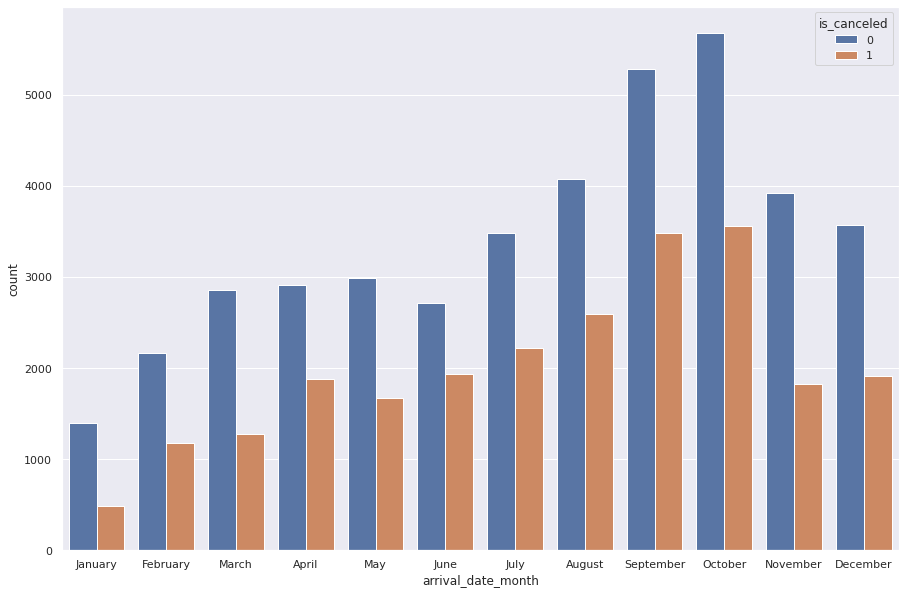

In [103]:
plt.figure(figsize=(15,10))
sns.barplot(x="arrival_date_month", y='count', hue="is_canceled", data=qtemp)

На графике сверху видно, что больше всего клиентов в летне-осенние месяцы.

<AxesSubplot:xlabel='arrival_date_month', ylabel='ratio'>

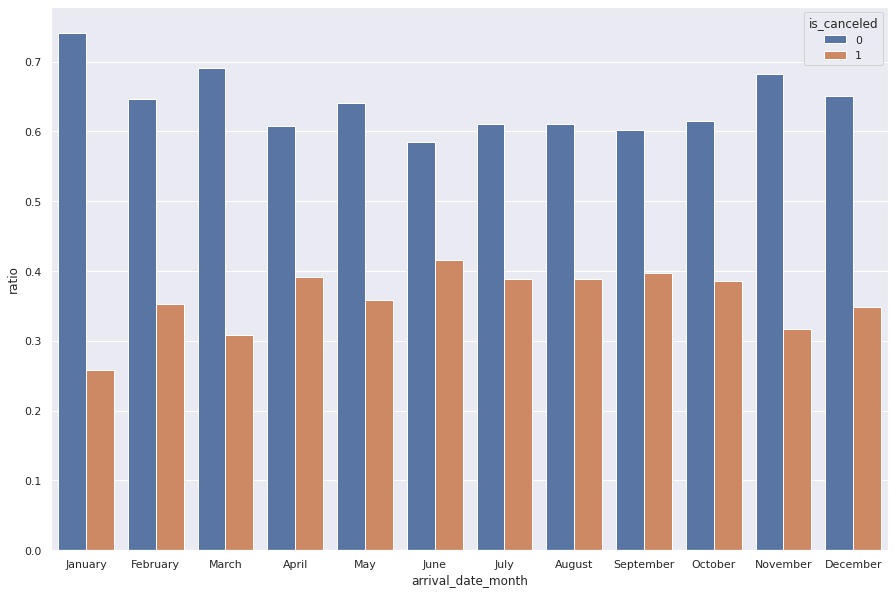

In [104]:
plt.figure(figsize=(15,10))
sns.barplot(x="arrival_date_month", y='ratio', hue="is_canceled", data=qtemp)

А на этом графике видно, что доля "отказных" клиентов в летне-осенние месяцы выше, чем в зимние. Наверное, здесь было бы правильно определить дополнительную категорию, где клиенты бронировали в "сезон" и "не сезон".

In [105]:
train['country'].nunique()

155

In [106]:
cat_features

['arrival_date_month',
 'meal',
 'country',
 'distribution_channel',
 'reserved_room_type',
 'customer_type',
 'is_repeated_guest']

Теперь посмотрим на корреляцию признаков между собой

<AxesSubplot:>

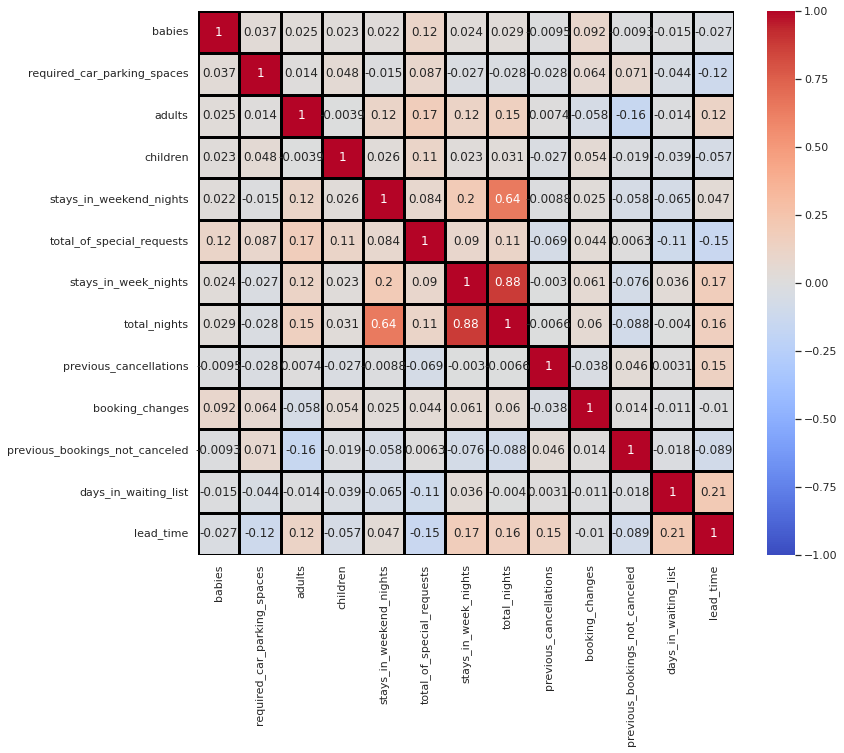

In [107]:
plt.figure(figsize = (12, 10))
sns.heatmap(train[num_features].corr(),
    annot = True,
    vmin=-1,
    vmax=1,
    center= 0,
    cmap= 'coolwarm',
    linewidths=3,
    linecolor='black',
    )

Самые коррелирующие признаки - *stays_in_week_nights*, *stays_in_weekend_nights*, *total_nights*.

Так как stays_in_weekend_nights и stays_in_week_nights тоже коррелируют между собой. то здесь оставим только total_nights. Также рассмотрем диаграмму рассеяния для некоторых значений

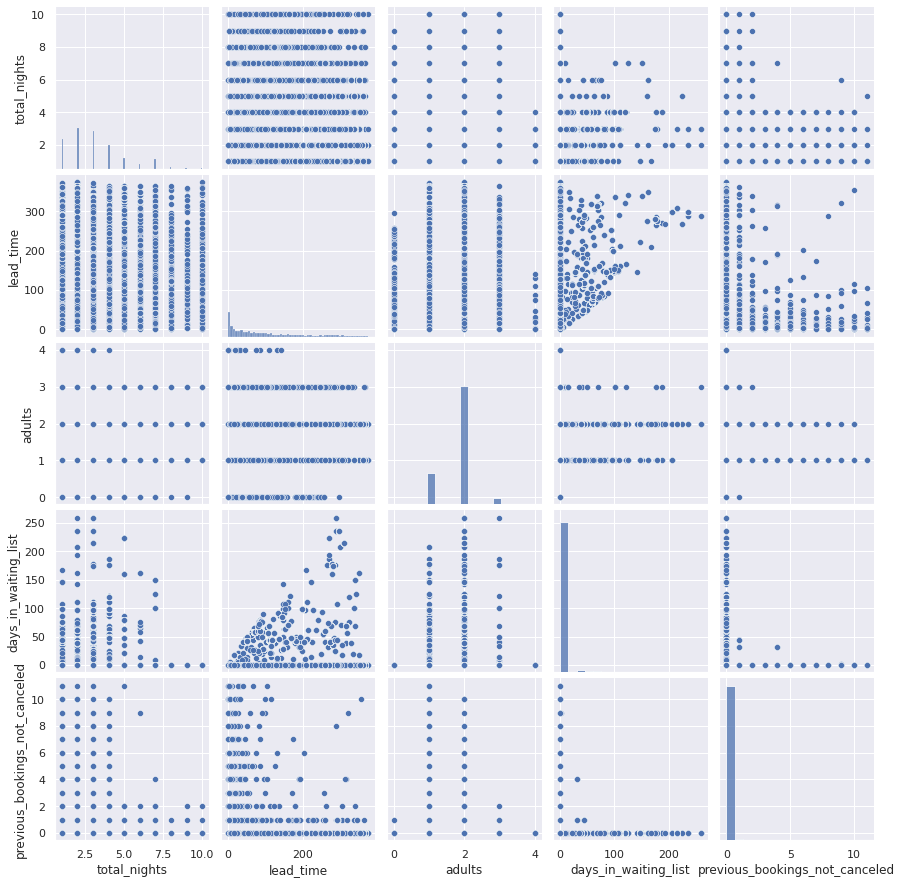

In [108]:
sns.pairplot(train[['total_nights',
                    'lead_time',
                    'adults',
                    'days_in_waiting_list',
                    'previous_bookings_not_canceled'
                   ]], kind="scatter")

Дропнем пока только stays_in_week_nights и stays_in_weekend_nights. На графике рассеяния еще может показаться, что зависимы между собой lead_time и days_in_waiting_list. Рассмотрим "приближенно".

In [109]:
len(num_features)

13

In [110]:
num_features = [x for x in num_features if x not in [
    'stays_in_week_nights', 'stays_in_weekend_nights']]
print(len(num_features))

11


<AxesSubplot:xlabel='lead_time', ylabel='days_in_waiting_list'>

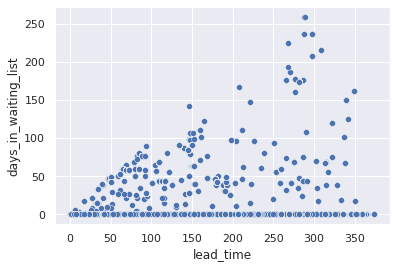

In [111]:
sns.scatterplot(data=train, x="lead_time", y="days_in_waiting_list", legend=False, sizes=(20, 2000))

Скорее подтверждение брони происходит в первый же день. Зависимость не установлена

### Выводы

В данном разделе произвели анализ данных. Данные содержат выбросы, если это будет препятствовать обучению модели, то строки с такими значениями придется удалить. Также были отобраны признаки для обучения модели. Коррелирующие между собой признаки были отброшены.

## Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

На этом этапе оценим выручку без внедрения депозитов. Считать будем так, как задано это в условии задачи. Проводить оценку будем на испытательной выборке (test).

Так как необходимо также учитывать сезонные коэффициенты, то в первую очередь определим весенние и осенние месяцы и летние месяцы.

In [112]:
temp = sorted(test['arrival_date_month'].unique())
display(temp)

['April', 'August', 'February', 'January', 'July', 'June', 'March', 'May']

In [113]:
summer = ['June', 'July', 'August']
autumn_spring = ['March', 'April', 'May', 'September', 'October', 'November']
winter = ['December', 'February', 'January']

In [114]:
temp_table = pd.DataFrame(temp, columns=['arrival_date_month'])

In [115]:
temp_table['season_coef'] = temp_table.apply(
    lambda x: 1.4 if x['arrival_date_month'] in summer else (
    1.2 if x['arrival_date_month'] in autumn_spring else 1
    ), axis=1
)

In [116]:
temp_table

,arrival_date_month,season_coef
0,April,1.200
1,August,1.400
2,February,1.000
3,January,1.000
4,July,1.400
5,June,1.400
6,March,1.200
7,May,1.200


Присоединим такую таблицу

In [117]:
len(test)

32412

In [118]:
test = pd.merge(test, temp_table, how='left', on='arrival_date_month')
display(test)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,season_coef
0,6086,1,74,2017,January,1,1,1,0,2,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1.000
1,6087,1,62,2017,January,1,1,2,2,2,0,0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.000
2,6088,1,62,2017,January,1,1,2,2,2,0,0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.000
3,6089,1,71,2017,January,1,1,2,2,1,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.000
4,6090,1,172,2017,January,1,1,2,5,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,97899,0,164,2017,August,35,31,2,4,2,0,0,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,0,6,1.400
32408,97900,0,21,2017,August,35,30,2,5,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,2,7,1.400
32409,97901,0,23,2017,August,35,30,2,5,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1.400
32410,97902,0,34,2017,August,35,31,2,5,2,0,0,BB,DEU,TA/TO,0,0,0,D,0,0,Transient,0,4,7,1.400


Теперь создадим таблицу со стоимостями номеров за ночь и единоразовой уборки. В данных даны два признака *reserved_room_type* и *assigned_room_type*. assigned_room_type - это по факту предоставленная категория номера, поэтому будем производить оценку именно по этому признаку

In [124]:
temp_table_category = \
pd.DataFrame([['A', 400, 1000],
              ['B', 250, 800],
              ['C', 250, 600],
              ['D', 150, 550],
              ['E', 150, 500],
              ['F', 150, 400],
              ['G', 150, 350],
              ['H', 100, 300]
             ],
             columns=['reserved_room_type', 'one_time_service', 'cost_per_night']
            )[['reserved_room_type', 'cost_per_night', 'one_time_service']]
display(temp_table_category)

,reserved_room_type,cost_per_night,one_time_service
0,A,1000,400
1,B,800,250
2,C,600,250
3,D,550,150
4,E,500,150
5,F,400,150
6,G,350,150
7,H,300,100


In [125]:
test = pd.merge(test, temp_table_category, how='left', on='reserved_room_type')
display(test)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,season_coef,cost_per_night,one_time_service
0,6086,1,74,2017,January,1,1,1,0,2,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1.000,1000,400
1,6087,1,62,2017,January,1,1,2,2,2,0,0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.000,1000,400
2,6088,1,62,2017,January,1,1,2,2,2,0,0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.000,1000,400
3,6089,1,71,2017,January,1,1,2,2,1,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.000,1000,400
4,6090,1,172,2017,January,1,1,2,5,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1.000,1000,400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,97899,0,164,2017,August,35,31,2,4,2,0,0,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,0,6,1.400,1000,400
32408,97900,0,21,2017,August,35,30,2,5,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,2,7,1.400,1000,400
32409,97901,0,23,2017,August,35,30,2,5,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1.400,1000,400
32410,97902,0,34,2017,August,35,31,2,5,2,0,0,BB,DEU,TA/TO,0,0,0,D,0,0,Transient,0,4,7,1.400,550,150


Теперь произведем расчет прибыли с учетом известных нам затрат (обслуживание). Считается, что отель терпит убытки, равные стоимости разового обслуживания, если клиент отменил бронирование. Если клиент не отменил бронирование, то обслуживание проводится каждые 2 дня + одно обслуживание перед датой заезда.

Соответственно:
1. Если клиент отказался от бронирования, то $Выручка = (-1) * РазовоеОбслуживание$;
2. Если клиент не отказался, то $Выручка = СтоимостьЗаНочь * СезонныйКоэффициент * ВсегоНочей - РазовоеОбслуживание * (ВсегоНочей // 2 + 1)$

Напишем функцию

In [126]:
def earnings(row):
    if row['is_canceled'] == 1:
        return (-1) * row['one_time_service']
    else:
        return (row['cost_per_night']
                * row['season_coef']
                * row['total_nights']
                - row['one_time_service']
                * (row['total_nights'] // 2 + 1)               
               )

In [127]:
test['earnings'] = test.apply(earnings, axis=1).value_counts()

In [128]:
test['earnings'] = test.apply(earnings, axis=1)

Проверим на случайной строке с индексом 32410

In [129]:
test

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,season_coef,cost_per_night,one_time_service,earnings
0,6086,1,74,2017,January,1,1,1,0,2,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1.000,1000,400,-400.000
1,6087,1,62,2017,January,1,1,2,2,2,0,0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.000,1000,400,-400.000
2,6088,1,62,2017,January,1,1,2,2,2,0,0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.000,1000,400,-400.000
3,6089,1,71,2017,January,1,1,2,2,1,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.000,1000,400,-400.000
4,6090,1,172,2017,January,1,1,2,5,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1.000,1000,400,-400.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,97899,0,164,2017,August,35,31,2,4,2,0,0,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,0,6,1.400,1000,400,6800.000
32408,97900,0,21,2017,August,35,30,2,5,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,2,7,1.400,1000,400,8200.000
32409,97901,0,23,2017,August,35,30,2,5,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1.400,1000,400,8200.000
32410,97902,0,34,2017,August,35,31,2,5,2,0,0,BB,DEU,TA/TO,0,0,0,D,0,0,Transient,0,4,7,1.400,550,150,4790.000


In [130]:
550 * 1.4 * 7 - 150 * (7 // 2 + 1)

4790.0

Все сходится. Рассчитаем суммарную прибыль

In [131]:
earnings_before = test['earnings'].sum()
print(earnings_before)

46342620.0


### Выводы

В этом разделе произвели расчет суммарной прибыли до внедрения депозитов. Суммарная прибыль составила 46342620.0

## Шаг 4. Разработка модели ML

Проведем обучение трех разных моделей машинного обучения и выберем наилучшую. 
1. Логистическая регрессия;
2. Дерево принятия решений;
3. Случайный лес.

Категориальные и численные признаки уже заранее обозначили

In [132]:
cat_features

['arrival_date_month',
 'meal',
 'country',
 'distribution_channel',
 'reserved_room_type',
 'customer_type',
 'is_repeated_guest']

In [133]:
cat_features.remove('arrival_date_month')

In [134]:
cat_features.remove('country')

In [135]:
num_features

['babies',
 'required_car_parking_spaces',
 'adults',
 'children',
 'total_of_special_requests',
 'total_nights',
 'previous_cancellations',
 'booking_changes',
 'previous_bookings_not_canceled',
 'days_in_waiting_list',
 'lead_time']

Так как испытательный набор уже обозначен, то дополнительно делить обучающий набор не будем.

In [136]:
X_train, y_train = train.copy(), train['is_canceled'].copy()

Посмотрим баланс классов в целевом признаке

In [137]:
y_train.mean()

0.36914164541012323

Есть небольшой перевес в сторону отрицательного класса, компенсируем это с помощью взвешивания. При обучении в качестве основной метрики выберем F1-меру, дополнительно будем измерять ROC-AUC

В начале произведем обработку всех переменных, используя пайплайн. Для категориальных признаков будем использовать прямое кодирование, а для численных - масштабирование. При этом для избежания дамми-ловушки будем удалять первый столбец для бинарных переменных

In [138]:
cat_pipe = Pipeline([('ohe', OneHotEncoder(
    sparse=False,
    drop='first',
    handle_unknown='ignore'))])

num_pipe = Pipeline([('scaler', StandardScaler())])

Соединяем пайплайны вместе

In [139]:
transformer = ColumnTransformer(
                           transformers=[('cat', cat_pipe, cat_features),
                                         ('num', num_pipe, num_features)], 
                                         remainder='drop', n_jobs=-1) 

Зададим функцию, которую будем оптимизировать. Она принимает на вход гиперпараметры, модель и данные, после чего возвращает точность на кросс-валидации:

In [140]:
def objective(params, pipeline,  X_train, y_train):
    """
    Кросс-валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: средняя точность на кросс-валидации
    """ 

    # задаём модели требуемые параметры    
    pipeline.set_params(**params)

    # задаём параметры кросс-валидации (стратифицированная 10-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=pipeline, X=X_train, y=y_train, 
                            scoring='f1', cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': (1-score.mean()), 'params': params, 'status': STATUS_OK}

### Логистическая регрессия

In [141]:
model_lr = Pipeline([('transformer', transformer),
                  ('lr', LogisticRegression(random_state=0, n_jobs=-1, 
                                            solver='liblinear',
                                            class_weight='balanced'))])

Сформируем пространство поиска параметров для hyperopt:

In [142]:
search_space_lr = {
                'lr__penalty' : hp.choice(label='penalty', 
                          options=['l1', 'l2']),
                'lr__C' : hp.loguniform(label='C', 
                        low=-4*np.log(10), 
                        high=2*np.log(10))
                }

Параметр регуляризации **C** выбирается из лог-равномерного распределения $[- 4ln10, 2ln10]$, и может принимать значения $[10^{-4}, 10^2]$, а тип регуляризации равновероятно выбирается из **[l1, l2]**

Укажем объект для сохранения истории поиска (Trials). Это очень удобно, т.к. можно сохранять, а также прерывать и затем продолжать процесс поиска гиперпараметров. Запускаем сам процесс подбора с помощью функции fmin. Укажем в качестве алгоритма поиска tpe.suggest – байесовскую оптимизацию. Количество итераций зададим 40.

In [143]:
rstate = np.random.RandomState(0)

In [80]:
trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective,
                       pipeline=model_lr,
                       X_train=X_train,
                       y_train=y_train),
          # пространство поиска гиперпараметров  
            space=search_space_lr,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
            max_evals=30,
          # куда сохранять историю поиска
            trials=trials,
          # ранняя остановка, если нет прогресса в 3 попытках подряд
            early_stop_fn=no_progress_loss(3),
          # random state
          # rstate=rstate # Здесь столкнулся с тем, что np выдает ошибку
          # 'numpy.random.mtrand.RandomState' object has no attribute 'integers'
          # пробовал обновить np, но не помогло, в предыдущем проекте все работало,
            show_progressbar=True
        )

 23%|██▎       | 7/30 [00:57<03:09,  8.23s/trial, best loss: 0.3189142377189734] 


In [83]:
def df_results(hp_results):
    """
    Отображаем результаты hyperopt в формате DataFrame 

    :hp_results: результаты hyperopt
    :return: pandas DataFrame
    """ 

    results = pd.DataFrame([{**x, **x['params']} for x in  hp_results])
    results.drop(labels=['status', 'params'], axis=1, inplace=True)
    results['score'] = 1 - results['loss']
    results.sort_values(by=['score'], ascending=False, inplace=True)

    return results

(0.0001, 200.0)

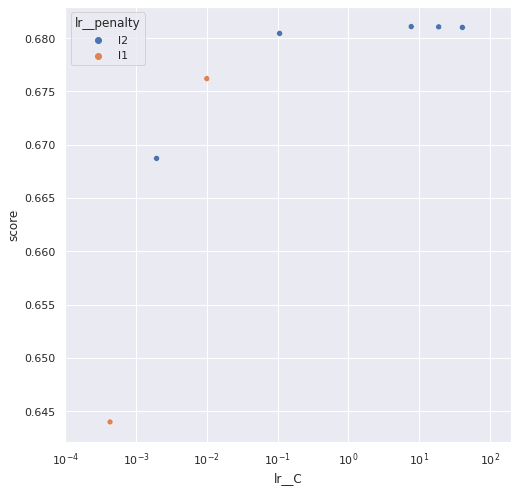

In [84]:
results = df_results(trials.results)
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x='lr__C', y='score', hue='lr__penalty', 
                                                   data=results);
ax.set_xscale('log')
ax.set_xlim(1e-4, 2e2)

На графике видно, что Hyperopt почти не исследовал районы, где получались низкие значения F1, а сосредоточился на районе с наибольшими значениями этой метрики.

In [85]:
best_params_lr = space_eval(search_space_lr, best)
best_params_lr['C'] = best_params_lr.pop('lr__C')
best_params_lr['penalty'] = best_params_lr.pop('lr__penalty')
print(best_params_lr)

{'C': 7.6851468677798715, 'penalty': 'l2'}


Теперь обучим модель, используя наилучшие гиперпараметры, на тренировочных данных целиком, а затем выведем показатели метрик F1 и ROC-AUC для тестового набора.

In [146]:
best_model_lr = Pipeline([('transformer', transformer),
                  ('lr', LogisticRegression(random_state=420,
                                            n_jobs=-1, 
                                            solver='liblinear',
                                            **{'C': 7.6851468677798715, 'penalty': 'l2'}
                                           ))]).fit(X_train, y_train)

Для отслеживания наилучшей метрики создадим табличку, которую будем заполнять по ходу исследования.
Расшифровка столбцов:

* 'model_name' - имя модели
* 'f1_train'- F1 на обучащей выборке
* 'f1_test' - F1 на тестовой выборке
* 'roc_auc_train' - ROC-AUC на обучащей выборке
* 'roc_auc_test'- ROC-AUC на тестовой выборке
* 'comment' - дополнительный комментарий
* 'F1_cross_val_score_mean' - осредненное количество очков на кросс-валидации

In [162]:
table_comp = pd.DataFrame(columns=[
                                  'model_name',
                                  'f1_train',
                                  'f1_test',
                                  'roc_auc_train',
                                  'roc_auc_test',
                                  'comment',
                                  'f1_cross_val_score_mean'])
display(table_comp)

,model_name,f1_train,f1_test,roc_auc_train,roc_auc_test,comment,f1_cross_val_score_mean


Для добавления в таблицу данных создадим функцию, которая будет возвращать массив для добавления в таблицу

In [161]:
def add_scores_to_table(model, model_name, f1_cross_val_score_mean, comment='None'):
    f1_train = f1_score(y_train, model.predict(X_train))
    f1_test = f1_score(y_test, model.predict(X_test))
    roc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
    roc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    return {'model_name':model_name,
          'f1_train':f1_train,
          'f1_test':f1_test,
          'roc_auc_train':roc_train,
          'roc_auc_test':roc_test,
          'f1_cross_val_score_mean': f1_cross_val_score_mean,
          'comment':comment}

Зададим испытательный набор и целевой признак

In [152]:
X_test, y_test = test.copy(), test['is_canceled'].copy()

In [163]:
table_comp = table_comp.append(add_scores_to_table(best_model_lr,
                                                   'Логистическая регрессия',
                                                   0.681 # посчитал вручную из Trials
                                                  ), ignore_index=True)

display(table_comp)

,model_name,f1_train,f1_test,roc_auc_train,roc_auc_test,comment,f1_cross_val_score_mean
0,Логистическая регрессия,0.678,0.599,0.827,0.783,None,0.681


Судя по метрикам, модель немного переобучилась, подстроившись под обучающий набор. Будет ли лучше, если добавим столбец country?

Будет ли качество лучше при добавлении столбца country?

In [164]:
cat_features.append('country')

In [96]:
trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective,
                       pipeline=model_lr,
                       X_train=X_train,
                       y_train=y_train),
          # пространство поиска гиперпараметров  
            space=search_space_lr,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
            max_evals=30,
          # куда сохранять историю поиска
            trials=trials,
          # ранняя остановка, если нет прогресса в 3 попытках подряд
            early_stop_fn=no_progress_loss(3),
          # random state
          # rstate=rstate # Здесь столкнулся с тем, что np выдает ошибку
          # 'numpy.random.mtrand.RandomState' object has no attribute 'integers'
          # пробовал обновить np, но не помогло, в предыдущем проекте все работало,
            show_progressbar=True
        )

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:1

  3%|▎         | 1/30 [00:26<12:55, 26.73s/trial, best loss: 0.27441634612932286]

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:1

  7%|▋         | 2/30 [00:32<09:33, 20.49s/trial, best loss: 0.27441634612932286]

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:1

 10%|█         | 3/30 [00:39<05:53, 13.08s/trial, best loss: 0.27441634612932286]


/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,



In [98]:
best_params_lr = space_eval(search_space_lr, best)
best_params_lr['C'] = best_params_lr.pop('lr__C')
best_params_lr['penalty'] = best_params_lr.pop('lr__penalty')
print(best_params_lr)

{'C': 39.40614911453661, 'penalty': 'l2'}


In [166]:
best_model_lr = Pipeline([('transformer', transformer),
                  ('lr', LogisticRegression(random_state=420,
                                            n_jobs=-1, 
                                            solver='liblinear',
                                            **{'C': 39.40614911453661, 'penalty': 'l2'}
                                           ))]).fit(X_train, y_train)

In [167]:
1 - 0.27441634612932286

0.7255836538706771

In [168]:
table_comp = table_comp.append(add_scores_to_table(best_model_lr,
                                                   'Логистическая регрессия',
                                                    0.725,
                                                   'добавлен country'
                                                  ), ignore_index=True)

display(table_comp)

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


,model_name,f1_train,f1_test,roc_auc_train,roc_auc_test,comment,f1_cross_val_score_mean
0,Логистическая регрессия,0.678,0.599,0.827,0.783,None,0.681
1,Логистическая регрессия,0.711,0.639,0.875,0.830,добавлен country,0.725


Метрики стали лучше

Периодически при обучении возникает такой варнинг:
/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

Это связано только со столбцом country. Не знаю, как фиксить. Только если игнорировать и убрать варнинги.

Попробуем также добавить столбец с месяцами

In [169]:
cat_features.append('arrival_date_month')

In [108]:
trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective,
                       pipeline=model_lr,
                       X_train=X_train,
                       y_train=y_train),
          # пространство поиска гиперпараметров  
            space=search_space_lr,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
            max_evals=30,
          # куда сохранять историю поиска
            trials=trials,
          # ранняя остановка, если нет прогресса в 3 попытках подряд
            early_stop_fn=no_progress_loss(3),
          # random state
          # rstate=rstate # Здесь столкнулся с тем, что np выдает ошибку
          # 'numpy.random.mtrand.RandomState' object has no attribute 'integers'
          # пробовал обновить np, но не помогло, в предыдущем проекте все работало,
            show_progressbar=True
        )

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:1

  3%|▎         | 1/30 [00:20<09:52, 20.41s/trial, best loss: 0.27422333289780865]

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:1

  7%|▋         | 2/30 [00:27<07:38, 16.36s/trial, best loss: 0.27422333289780865]

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:1

 10%|█         | 3/30 [00:33<05:00, 11.14s/trial, best loss: 0.27422333289780865]


/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,



In [109]:
best_params_lr = space_eval(search_space_lr, best)
best_params_lr['C'] = best_params_lr.pop('lr__C')
best_params_lr['penalty'] = best_params_lr.pop('lr__penalty')
print(best_params_lr)

{'C': 2.8010709737079744, 'penalty': 'l2'}


In [170]:
best_model_lr = Pipeline([('transformer', transformer),
                  ('lr', LogisticRegression(random_state=420,
                                            n_jobs=-1, 
                                            solver='liblinear',
                                            **{'C': 2.8010709737079744, 'penalty': 'l2'}
                                           ))]).fit(X_train, y_train)

In [172]:
table_comp = table_comp.append(add_scores_to_table(best_model_lr,
                                                   'Логистическая регрессия',
                                                   0.726,
                                                   '+ месяцы, + страны'
                                                  ), ignore_index=True)

display(table_comp)

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


,model_name,f1_train,f1_test,roc_auc_train,roc_auc_test,comment,f1_cross_val_score_mean
0,Логистическая регрессия,0.678,0.599,0.827,0.783,None,0.681
1,Логистическая регрессия,0.711,0.639,0.875,0.830,добавлен country,0.725
2,Логистическая регрессия,0.711,0.636,0.875,0.830,"+ месяцы, + страны",0.726


При добавлении месяцев метрики не улучшились, отбросим их

In [173]:
cat_features.remove('arrival_date_month')

### Случайный лес

In [175]:
model_rf = Pipeline([('transformer', transformer),
                  ('rf', RandomForestClassifier(n_jobs=-1,
                                                random_state=42,
                                                class_weight='balanced'))])

In [176]:
search_space_rf = {
                      'rf__criterion' : hp.choice(
                          label='criterion',
                          options=['gini', 'entropy']),
                      'rf__n_estimators' : scope.int(hp.quniform(
                          'n_estimators', 100, 500, 1)),
                      'rf__max_depth' : scope.int(hp.quniform(
                          'max_depth', 1, 10, 1)),
                      'rf__min_samples_split' :  scope.int(hp.quniform(
                          'min_samples_split', 2, 40, 1)),
                      'rf__min_samples_leaf' :  scope.int(hp.quniform(
                          'min_samples_leaf', 1, 20, 1))
}

In [144]:
trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective,
                       pipeline=model_rf,
                       X_train=X_train,
                       y_train=y_train),
          # пространство поиска гиперпараметров  
            space=search_space_rf,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
            max_evals=50,
            early_stop_fn=no_progress_loss(5),
          # куда сохранять историю поиска
            trials=trials,
          # random state
           #rstate=np.random.RandomState(420),
          # progressbar
           show_progressbar=True
        )

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:1

  2%|▏         | 1/50 [02:03<1:41:09, 123.87s/trial, best loss: 0.26415766197921464]

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:1

  4%|▍         | 2/50 [03:36<1:31:39, 114.57s/trial, best loss: 0.23952965960979777]

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:1

  6%|▌         | 3/50 [05:19<1:27:02, 111.11s/trial, best loss: 0.23952965960979777]

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:1

  8%|▊         | 4/50 [06:05<1:10:02, 91.37s/trial, best loss: 0.23952965960979777] 

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:1

 10%|█         | 5/50 [09:28<1:33:41, 124.92s/trial, best loss: 0.23952965960979777]

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:1

 12%|█▏        | 6/50 [10:58<1:24:04, 114.65s/trial, best loss: 0.23952965960979777]

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:1

 14%|█▍        | 7/50 [15:53<2:00:54, 168.70s/trial, best loss: 0.2388623288807361] 

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:1

 16%|█▌        | 8/50 [17:25<1:41:58, 145.69s/trial, best loss: 0.2388623288807361]

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:1

 18%|█▊        | 9/50 [20:01<1:41:38, 148.75s/trial, best loss: 0.2388623288807361]

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:1

 20%|██        | 10/50 [23:05<1:46:10, 159.27s/trial, best loss: 0.2388623288807361]

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:1

 22%|██▏       | 11/50 [28:16<2:13:08, 204.84s/trial, best loss: 0.2388623288807361]

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:1

 24%|██▍       | 12/50 [30:13<1:35:43, 151.14s/trial, best loss: 0.2388623288807361]


/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,



In [177]:
1- 0.2388623288807361

0.7611376711192639

In [145]:
results = df_results(trials.results)
display(results.head(10))

,loss,rf__criterion,rf__max_depth,rf__min_samples_leaf,rf__min_samples_split,rf__n_estimators,score
6,0.239,gini,10,14,27,464,0.761
8,0.239,gini,9,5,36,248,0.761
10,0.239,gini,9,5,3,493,0.761
1,0.240,entropy,9,1,26,142,0.760
4,0.241,entropy,9,9,6,290,0.759
9,0.242,gini,9,16,32,300,0.758
5,0.245,gini,8,16,14,153,0.755
11,0.253,entropy,6,19,5,226,0.747
2,0.261,gini,5,6,34,221,0.739
7,0.261,gini,5,5,28,202,0.739


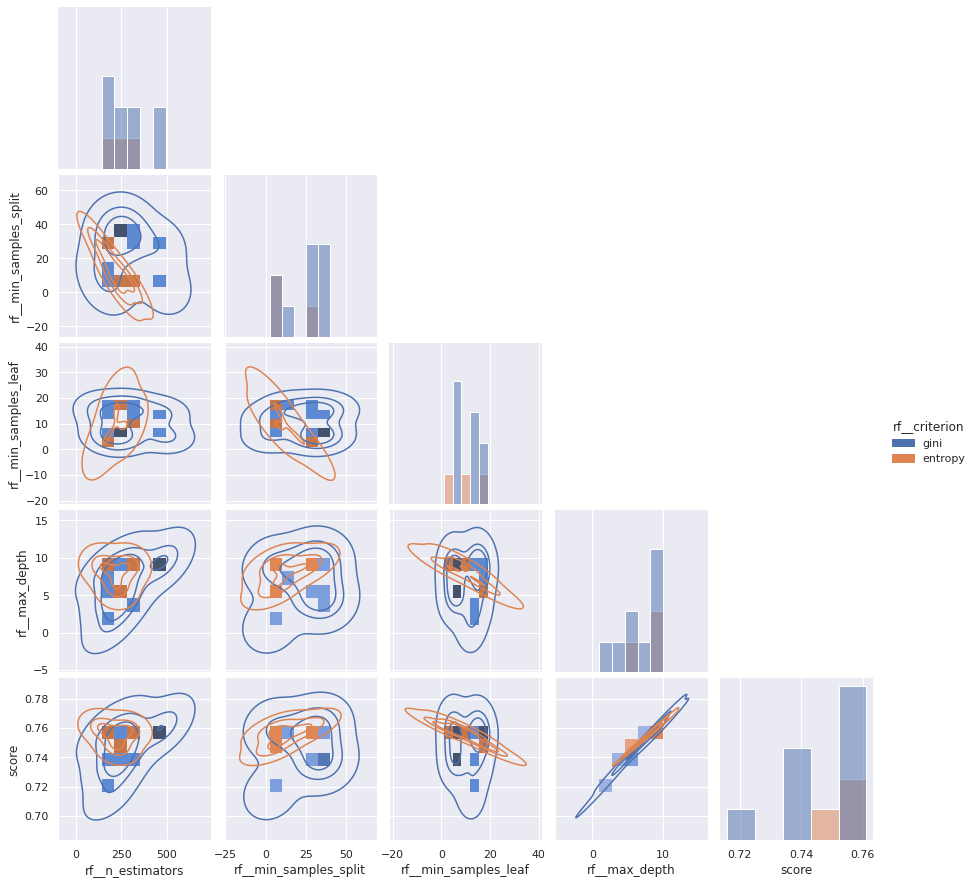

In [147]:
sns.pairplot(results[['rf__n_estimators',
                      'rf__min_samples_split',
                      'rf__min_samples_leaf',
                      'rf__max_depth',
                      'score',
                      'rf__criterion']],
             kind='hist', corner=True, hue='rf__criterion').map_lower(sns.kdeplot, levels=4, color=".2")

Видим, что модель выбирала значения в районе, где была достигнуто наилучшее значение метрики.

Обучим модель с наилучшими параметрами, а затем данные добавим в таблицу

In [148]:
best_params_rf = space_eval(search_space_rf, best)
best_params_rf['criterion'] = best_params_rf.pop('rf__criterion')
best_params_rf['max_depth'] = best_params_rf.pop('rf__max_depth')
best_params_rf['min_samples_leaf'] = best_params_rf.pop('rf__min_samples_leaf')
best_params_rf['min_samples_split'] = best_params_rf.pop('rf__min_samples_split')
best_params_rf['n_estimators'] = best_params_rf.pop('rf__n_estimators')
print(best_params_rf)

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 14, 'min_samples_split': 27, 'n_estimators': 464}


In [178]:
best_model_rf = Pipeline([('transformer', transformer),
                  ('rf', RandomForestClassifier(n_jobs=-1, random_state=420,
                                                class_weight='balanced',
                                                   **{'criterion': 'gini',
                                                      'max_depth': 10,
                                                      'min_samples_leaf': 14,
                                                      'min_samples_split': 27,
                                                      'n_estimators': 464}))]).fit(X_train, y_train)


In [179]:
table_comp = table_comp.append(add_scores_to_table(best_model_rf, 'Случайный лес', 0.761, '+ страны'), ignore_index=True)
display(table_comp)

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


,model_name,f1_train,f1_test,roc_auc_train,roc_auc_test,comment,f1_cross_val_score_mean
0,Логистическая регрессия,0.678,0.599,0.827,0.783,None,0.681
1,Логистическая регрессия,0.711,0.639,0.875,0.830,добавлен country,0.725
2,Логистическая регрессия,0.711,0.636,0.875,0.830,"+ месяцы, + страны",0.726
3,Случайный лес,0.762,0.674,0.898,0.843,+ страны,0.761


### Выводы по выбору модели

Наилучшие значения метрик были достигнуты с помощью модели случайного леса. Эту модель и будем использовать для расчета окупаемости затрат на внедрение депозитов. Обратим также внимание, что в условии задачи не указано, что ошибки первого рода (False Positive) как-либо штрафуются.

### Оценка модели с точки зрения бизнеса

Для оценки модели присоединим прогнозы к таблице test

In [180]:
y_pred = best_model_rf.predict(X_test)

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


In [181]:
len(y_pred)

32412

In [182]:
len(test)

32412

In [183]:
test['y_pred'] = y_pred

In [184]:
test

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,season_coef,cost_per_night,one_time_service,earnings,y_pred
0,6086,1,74,2017,January,1,1,1,0,2,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1.000,1000,400,-400.000,1
1,6087,1,62,2017,January,1,1,2,2,2,0,0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.000,1000,400,-400.000,0
2,6088,1,62,2017,January,1,1,2,2,2,0,0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.000,1000,400,-400.000,0
3,6089,1,71,2017,January,1,1,2,2,1,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.000,1000,400,-400.000,1
4,6090,1,172,2017,January,1,1,2,5,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1.000,1000,400,-400.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,97899,0,164,2017,August,35,31,2,4,2,0,0,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,0,6,1.400,1000,400,6800.000,0
32408,97900,0,21,2017,August,35,30,2,5,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,2,7,1.400,1000,400,8200.000,0
32409,97901,0,23,2017,August,35,30,2,5,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1.400,1000,400,8200.000,0
32410,97902,0,34,2017,August,35,31,2,5,2,0,0,BB,DEU,TA/TO,0,0,0,D,0,0,Transient,0,4,7,1.400,550,150,4790.000,0


Дополнительно рассчитывать ничего не будем, напишем функцию, где:
* Если клиент отказался от бронирования, и модель это предсказала, то будет списан депозит в сумме 80% от стоимости за ночь, умноженной на коэффициент;
* В остальных случаях вернется ноль.

In [185]:
# На вход передаем строку и столбец с предсказаниями
def earnings_deposites(row):
    if (row['is_canceled'] == 1) and (row['y_pred'] == 1):
        return row['cost_per_night'] * row['season_coef'] * 0.8
    else:
        return 0

In [186]:
test['deposites'] = test.apply(earnings_deposites, axis=1)

Теперь можем рассчитать выручку с учетом внедрения депозитов. Бюджет на разработку составляет 400 тыс. рублей

In [187]:
earnings_after = (test['earnings'] + test['deposites']).sum()
print(earnings_after)

53125764.0


In [188]:
total = earnings_after - earnings_before
print('Разница выручек после внедрения депозитов и до составляет:', total)

Разница выручек после внедрения депозитов и до составляет: 6783144.0


### Выводы

Сумма, полученная в результате внедрения депозитов окупит затраты на разработку в первый же год.

## Шаг 5. Опишите портрет «ненадёжного» клиента

Для этого мы используем метод feature_importances_

In [189]:
values = best_model_rf[1].feature_importances_
print(values)

[1.68557472e-03 2.13221567e-03 5.86945424e-03 1.83639015e-02
 4.55917626e-05 3.65562862e-02 5.46593915e-04 1.75589901e-04
 4.56195703e-03 1.44846697e-03 3.71796954e-04 1.21295199e-04
 8.08870335e-04 3.25817965e-02 2.83603476e-02 3.61548639e-03
 1.31920415e-04 0.00000000e+00 0.00000000e+00 4.94241911e-05
 2.08993206e-05 0.00000000e+00 0.00000000e+00 9.27882185e-05
 2.39351207e-03 0.00000000e+00 0.00000000e+00 2.06440125e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.45517798e-07
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.29118991e-04 0.00000000e+00 0.00000000e+00 1.06507158e-03
 1.03318604e-06 9.17166430e-04 0.00000000e+00 0.00000000e+00
 6.00067213e-04 4.33467944e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.06915706e-05
 1.84589168e-02 0.00000000e+00 1.52134112e-04 0.00000000e+00
 4.04346383e-05 0.00000000e+00 0.00000000e+00 7.25526985e-03
 7.28968535e-07 0.00000000e+00 3.32592631e-04 2.80696086e-02
 0.00000000e+00 1.343423

In [190]:
best_model_rf.steps

[('transformer',
  ColumnTransformer(n_jobs=-1,
                    transformers=[('cat',
                                   Pipeline(steps=[('ohe',
                                                    OneHotEncoder(drop='first',
                                                                  handle_unknown='ignore',
                                                                  sparse=False))]),
                                   ['meal', 'distribution_channel',
                                    'reserved_room_type', 'customer_type',
                                    'is_repeated_guest', 'country']),
                                  ('num',
                                   Pipeline(steps=[('scaler', StandardScaler())]),
                                   ['babies', 'required_car_parking_spaces',
                                    'adults', 'children',
                                    'total_of_special_requests', 'total_nights',
                                    'previ

In [191]:
cat_names = best_model_rf[0].transformers_[0][1].named_steps['ohe'].get_feature_names(cat_features).tolist()
num_names = num_features

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [192]:
names = [*cat_names, *num_names]

In [193]:
feature_importances = pd.DataFrame(zip(names, values),
                                   columns=['name', 'value']
                                  ).sort_values('value', ascending=False)
display(feature_importances.head(20))

,name,value
132,country_PRT,0.203
180,lead_time,0.137
176,previous_cancellations,0.135
174,total_of_special_requests,0.133
171,required_car_parking_spaces,0.056
177,booking_changes,0.048
5,distribution_channel_TA/TO,0.037
13,customer_type_Transient,0.033
14,customer_type_Transient-Party,0.028
63,country_FRA,0.028


Судя по этой таблице, самым весомым признаком при прогнозировании отмены бронирования - это, является ли клиент гражданом Португалии. Т.е. можно предположить, что граждане этой страны наиболее часто отменяли бронирования или наоборот. Также в топ-5 вошли признаки:
* количество дней между датой бронирования и датой заезда;
* количество отмен бронирования до этого момента;
* количество специальных запросов.

Проанализируем эти показатели:

In [194]:
train[train['country'] == 'PRT']['is_canceled'].mean()

0.5779039788168072

57 процентов граждан Португалии отменили бронирование. Это говорит о том, что Португалец скорее всего "ненадежный" клиент.

<AxesSubplot:xlabel='lead_time', ylabel='Count'>

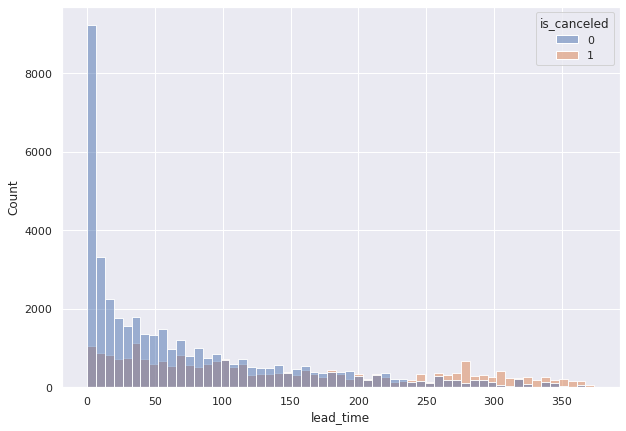

In [233]:
plt.figure(figsize=(10, 7))
sns.histplot(train, x='lead_time', hue='is_canceled')

Те, кто бронируют сильно заранее обычно отменяют бронь. Особенно это хорошо заметно, если lead_time больше 200

(0.0, 100.0)

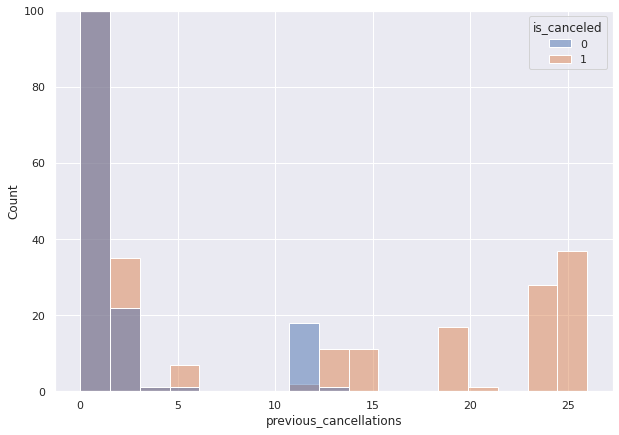

In [235]:
plt.figure(figsize=(10, 7))
sns.histplot(train, x='previous_cancellations', hue='is_canceled')
plt.ylim(0, 100)

Ненадежным клиентом также считается тот, кто ранее отменял уже бронирование.

<AxesSubplot:xlabel='total_of_special_requests', ylabel='Count'>

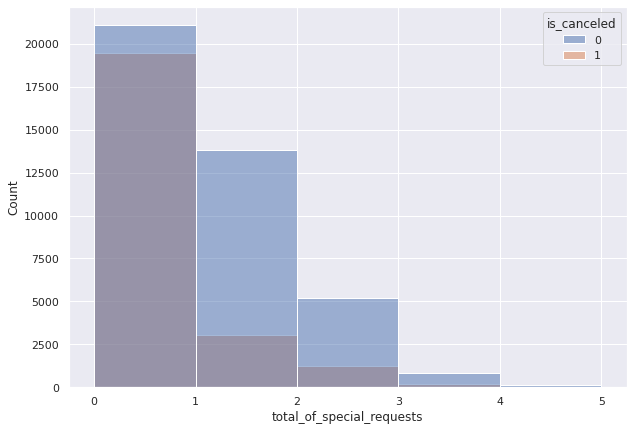

In [238]:
plt.figure(figsize=(10, 7))
sns.histplot(train, x='total_of_special_requests', hue='is_canceled', bins=5)

Вот здесь, кстати, спорно. Возможно, данный фактор работает с каким-то другим в совокупности.

Портрет ненадежного клиента:
* Из Португалии;
* Забронировал заранее;
* Есть отмены предыдущих бронирований;

## Шаг 6. Напишите общий вывод

В результате проведенного исследования была расчитана прибыль до внедрения депозитов и после внедрения депозитов. Были испытаны три алгоритма машинного обучения:
* Логистическая регрессия;
* Метод К ближайших соседей;
* Случайный лес.

Наилучшие результаты показал алгоритм случайного леса, сравнивали по F1-мере и ROC-AUC на тестовой выборке. После внедрения депозитов разница между прибылями 'до' и 'после' составила 6783144.0, что значительно выше затрат на внедрение. Разработанная система предсказания депозитов рекомендуется к использованию, но предварительно также необходимо оценить риски влияния ложно-положительных пронозов на отмену бронирования желательными клиентами.

На основании значимости признаков модели обучения был составлен портрет нежелательного клиента. Такой клиент чаще всего:
* Из Португалии;
* Забронировал заранее;
* Есть отмены предыдущих бронирований;
* Есть специальные запросы.